# CS5489 - Machine Learning
# Lecture 4b - Non-linear Classifiers
## Dr. Antoni B. Chan
### Dept. of Computer Science, City University of Hong Kong

# Outline
1. Nonlinear classifiers
2. Kernel trick and kernel SVM
3. **Ensemble Methods - Boosting, Random Forests**
4. Classification Summary

In [1]:
# setup
%matplotlib inline
import IPython.core.display         # setup output image format (Chrome works best)
IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
from scipy import stats

In [2]:
def drawstump(fdim, fthresh, fdir='gt', poscol=None, negcol=None, lw=2, ls='k-'):
    # fdim = dimension
    # fthresh = threshold
    # fdir = direction (gt, lt)
    
    if fdir == 'lt':
        # swap colors
        tmp = poscol
        poscol = negcol
        negcol = tmp
    
    # assume fdim=0
    polyxn = [fthresh, fthresh, -30, -30]
    polyyn = [30, -30, -30, 30]
    
    polyxp = [fthresh, fthresh, 30, 30]
    polyyp = [30, -30, -30, 30]
        
    # fill positive half-space or neg space
    if (poscol):
        if fdim==0:
            plt.fill(polyxp, polyyp, poscol, alpha=0.2)
        else:
            plt.fill(polyyp, polyxp, poscol, alpha=0.2)            
    
    if (negcol):
        if fdim==0:
            plt.fill(polyxn, polyyn, negcol, alpha=0.2)
        else:
            plt.fill(polyyn, polyxn, negcol, alpha=0.2)

    # plot line
    if fdim==0:
        plt.plot(polyxp[0:2], polyyp[0:2], ls, lw=lw)
    else:
        plt.plot(polyyp[0:2], polyxp[0:2], ls, lw=lw)

def drawplane(w, b=None, c=None, wlabel=None, poscol=None, negcol=None, lw=2, ls='k-'):
    # w^Tx + b = 0
    # w0 x0 + w1 x1 + b = 0
    # x1 = -w0/w1 x0 - b / w1

    # OR
    # w^T (x-c) = 0 = w^Tx - w^Tc  --> b = -w^Tc
    if c != None:
        b = -sum(w*c)
    
    # the line
    if (abs(w[0])>abs(w[1])):   # vertical line
        x0 = array([-30,30])
        x1 = -w[0]/w[1] * x0 - b / w[1]
    else:                       # horizontal line
        x1 = array([-30,30])
        x0 = -w[1]/w[0] * x1 - b / w[0]
    
    # fill positive half-space or neg space
    if (poscol):
        polyx = [x0[0], x0[-1], x0[-1], x0[0]]
        polyy = [x1[0], x1[-1], x1[0], x1[0]]
        plt.fill(polyx, polyy, poscol, alpha=0.2)
    
    if (negcol):
        polyx = [x0[0], x0[-1], x0[0], x0[0]]
        polyy = [x1[0], x1[-1], x1[-1], x1[0]]
        plt.fill(polyx, polyy, negcol, alpha=0.2)
        
    # plot line
    lineplt, = plt.plot(x0, x1, ls, lw=lw)

    # the w
    if (wlabel):
        xp = array([0, -b/w[1]])
        xpw = xp+w
        plt.arrow(xp[0], xp[1], w[0], w[1], width=0.01)
        plt.text(xpw[0]-0.5, xpw[1], wlabel)
    return lineplt

# Ensemble Classifiers
- _Why trust only one expert?_
  - In real life, we may consult several experts, or go with the "wisdom of the crowd"  
  - In machine learning, _why trust only one classifier?_

- Ensemble methods aim to combine multiple classifiers together to form a better classifier.
- Examples:
  - **boosting** - training multiple classifiers, each focusing on errors made by previous classifiers.
  - **bagging** - training multiple classifiers from random selection of training data

# AdaBoost - Adaptive Boosting
- Base classifier is a "weak learner" 
  - A simple classifier that can be slightly better than random chance (>50%)
  - Example: _decision stump classifier_  
    - check if feature value is above (or below) a threshold.
    - $y = h(x) = \begin{cases}+1, & x_j \geq T \\ -1, & x_j\lt T \end{cases}$


In [3]:
# type three - moons
X3,Y3 = datasets.samples_generator.make_moons(n_samples=100,
                                             noise=0.1, random_state=4487)
mycmap = matplotlib.colors.LinearSegmentedColormap.from_list('mycmap', ["#FF0000", "#FFFFFF", "#00FF00"])

axbox3 = [-1.5, 2.5, -1, 1.5]

wlfig = plt.figure(figsize=(9,3))
plt.subplot(1,2,1)
drawstump(0, 0, poscol='g', negcol='r')
plt.scatter(X3[:,0], X3[:,1], c=Y3, cmap=mycmap, edgecolors='k')
plt.xlabel('$x_1$'); plt.ylabel('$x_2$'); plt.grid(True)
plt.axis(axbox3)
plt.title('$f(\mathbf{x}) = (x_1>0)$')

plt.subplot(1,2,2)
drawstump(1, 0.5, fdir='lt', poscol='g', negcol='r')
plt.scatter(X3[:,0], X3[:,1], c=Y3, cmap=mycmap, edgecolors='k')
plt.xlabel('$x_1$'); plt.ylabel('$x_2$'); plt.grid(True)
plt.axis(axbox3)
plt.title('$f(\mathbf{x}) = (x_2<0.5)$')
plt.close()

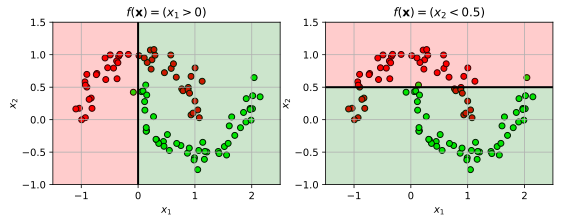

In [4]:
wlfig

- **Idea:** train weak classifiers sequentially
- In each iteration,
  - Pick a weak learner $h_t(\mathbf{x})$ that best carves out the input space.
  - The weak learner should focus on data that is misclassified.
    - Apply weights to each sample in the training data.
    - Higher weights give more priority to difficult samples.
  - Combine all the weak learners into a strong classifier: $f_t(\mathbf{x}) = f_{t-1}(\mathbf{x}) + \alpha_t h_t(\mathbf{x})$
    - $\alpha_t$ is a weight for each weak learner.

In [5]:
def plot_boosting(model, axbox, X):

    # grid points
    xr = [ linspace(axbox[0], axbox[1], 200), 
           linspace(axbox[2], axbox[3], 200) ]

    # make a grid for calculating the posterior, 
    #  then form into a big [N,2] matrix
    xgrid0, xgrid1 = meshgrid(xr[0], xr[1])
    allpts = c_[xgrid0.ravel(), xgrid1.ravel()]

    # calculate the decision function
    if hasattr(model, 'decision_function'):
        score = model.decision_function(allpts).reshape(xgrid0.shape)
    else:
        score = model.predict_proba(allpts)[:,1].reshape(xgrid0.shape)  
        # pass through a logit
        score = log(score / (1-score))
    maxscore = ceil(abs(score).max())
    mylevels = linspace(-maxscore, maxscore, 11)

    plt.imshow(score, origin='lower', extent=axbox, alpha=0.30, cmap=mycmap, 
               vmin=-maxscore, vmax=maxscore, aspect='auto')

    #plt.contourf(xr[0], xr[1], score, levels=mylevels, cmap=mycmap, alpha=0.3)
    plt.contour(xr[0], xr[1], score, levels=[0], linestyles='solid', colors='k',
                linewidths=2)
    
    plt.axis(axbox); plt.grid(True)    

In [6]:
plts = {}
ns = [1, 2, 3, 4, 5]
N = X3.shape[0]
XW = ones(N) / N

for n in ns:
    # run the discrete Boosting algorithm
    clf = ensemble.AdaBoostClassifier(n_estimators=n, random_state=4487, algorithm='SAMME')
    clf.fit(X3, Y3)

    plts[n] = plt.figure(figsize=(9,3))
    
    # show the weak learner
    wl = clf.estimators_[n-1]
    wlf = wl.tree_.feature[0]
    wlt = wl.tree_.threshold[0]

    if wl.tree_.value[2,0,1] > wl.tree_.value[2,0,0]:
        wld = 'gt'
    else:
        wld = 'lt'
    
    plt.subplot(1,2,1)
    drawstump(wlf, wlt, fdir=wld, poscol='g', negcol='r')
    mys = 20*sqrt(XW*N)
    plt.scatter(X3[:,0], X3[:,1], c=Y3, s=mys, cmap=mycmap, edgecolors='k')
    plt.xlabel('$x_1$'); plt.ylabel('$x_2$')
    plt.axis(axbox3); plt.grid(True)
    plt.title('iter '+str(n) + " weak learner")

    plt.subplot(1,2,2)
    plot_boosting(clf, axbox3, X3)
    plt.scatter(X3[:,0], X3[:,1], c=Y3, cmap=mycmap, edgecolors='k')

    plt.xlabel('$x_1$'); plt.ylabel('$x_2$')
    plt.title('iter '+str(n) + " classifier")
        
    # calculate updated weights (for AdaBoost)
    # can't find these in the sklearn version
    tmpY = clf.estimators_[n-1].predict(X3)
    err = sum((tmpY != Y3)*XW)
    alpha = 0.5*log((1-err) / err)
    scale = 2*(tmpY!=Y3)-1
    XW = XW * exp(scale*alpha)
    XW = XW / sum(XW)
    plt.close()

# Iteration 1
- Initially, weights for all training samples are equal: $w_i = 1/N$
  - Pick best weak learner $h_1(\mathbf{x})$.

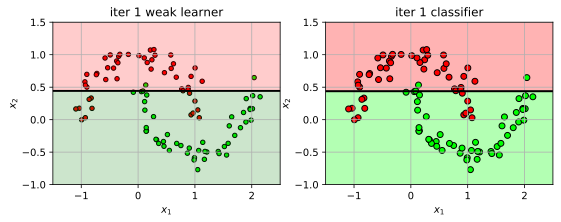

In [7]:
plts[1]

# Iteration 2 (part 1)
- points are re-weighted based on the previous errors:
  - increase weights for misclassified samples: $w_i = w_i e^{\alpha}$
  - decrease weights for correctly classified samples: $w_i = w_i e^{-\alpha}$
  - $\alpha = 0.5 \log \frac{1-err}{err}$ is based on the weighted error of the previous weak learner.
  - (larger circles indicates higher weight)

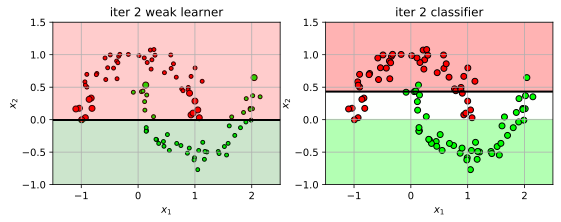

In [8]:
plts[2]

# Iteration 2 (part 2)
- using the weighted data, train another weak learner $h_2(\mathbf{x})$.
- the classifier function is the weighted sum of weak learners
  - $f_2(\mathbf{x}) =  f_1(\mathbf{x}) + \alpha_2 h_2(\mathbf{x})$

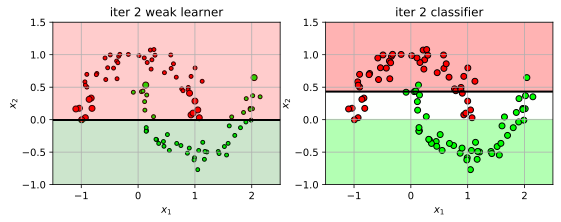

In [9]:
plts[2]

# Keep iterating...

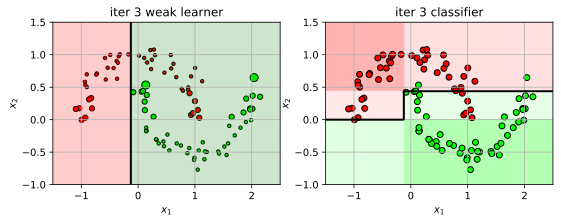

In [10]:
plts[3]

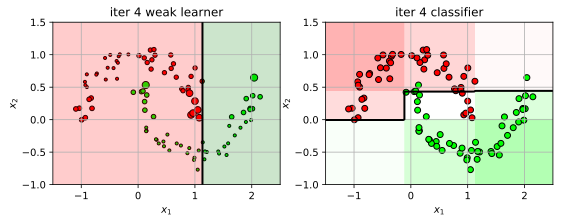

In [11]:
plts[4]

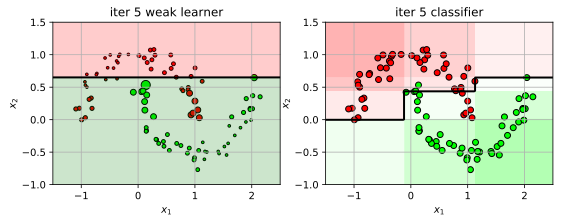

In [12]:
plts[5]

- After many iterations...

In [13]:
ns = [10, 50, 100, 1000]

adafig = plt.figure(figsize=(9,9))
for i,n in enumerate(ns):
    clf = ensemble.AdaBoostClassifier(n_estimators=n, random_state=4487)
    clf.fit(X3, Y3)
    
    plt.subplot(2,2,i+1)
    plot_boosting(clf, axbox3, X3)
    plt.scatter(X3[:,0], X3[:,1], c=Y3, cmap=mycmap, edgecolors='k')
    plt.xlabel('$x_1$'); plt.ylabel('$x_2$')
    plt.gca().xaxis.set_ticklabels([])
    plt.gca().yaxis.set_ticklabels([])
    plt.title('iter '+str(n) + " classifier")
plt.close()

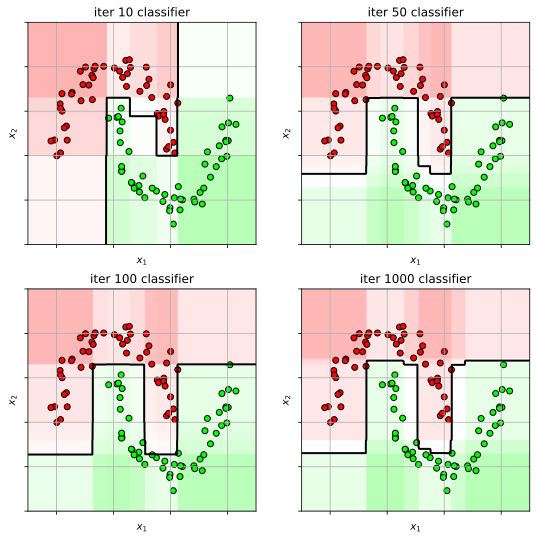

In [14]:
adafig

...

# Adaboost Algorithm
- Given data $\{(\mathbf{x}_i, y_i)\}$.
- Initialize data weights, $w_i=1/N, \forall i$.
- For $t$ = 1 to T,
  - choose weak learner $h_t(\mathbf{x})$
    - minimize the weighted classification error: $\epsilon_t = \sum_{i=1}^N w_i  \mathbb{1}(h_t(\mathbf{x}_i) \neq y_i)$.
  - Set the weak learner weight: $\alpha_t = \frac{1}{2}\log(\frac{1-\epsilon_t}{\epsilon_t})$
  - Add to ensemble: $f_t(\mathbf{x}) = f_{t-1}(\mathbf{x}) + \alpha_t h_t(\mathbf{x})$.
  - Update data weights:
    - for all  $\mathbf{x}_i$ misclassified, increase weight: $w_i \leftarrow w_i e^{\alpha_t}$.
    - for all $\mathbf{x}_i$ correctly classified, decrease weight: $w_i \leftarrow w_i e^{-\alpha_t}$.
    - normalize weights, so that $\sum_i w_i = 1$.

# Adaboost loss function
- It can be shown that Adaboost is minimizing:
  $$\min_f \sum_i e^{-y_i f(\mathbf{x}_i)}$$

- Thus, it is an exponential loss function
  - $L(z_i) = e^{-z_i}$
    - $z_i = y_i  f(\mathbf{x}_i)$
  - very sensitive to misclassified outliers.

In [15]:
z = linspace(-6,6,100)
logloss = log(1+exp(-z))
hingeloss = maximum(0, 1-z)
exploss = exp(-z)
lossfig = plt.figure()
plt.plot(z,exploss, 'b-')

plt.plot([0,0], [0,9], 'k--')
plt.text(0,7.5, "incorrectly classified $\\Leftarrow$ ", ha='right', weight='bold')
plt.text(0,7.5, " $\Rightarrow$ correctly classified", ha='left', weight='bold')

plt.annotate(s="loss increases\nsignificantly for\nmisclassified\nsamples", 
             xy=(-1.6,5), xytext=(-3.5,2.2),backgroundcolor='white',
            arrowprops=dict(arrowstyle="->"))
plt.annotate(s="non-zero loss\nfor samples\nnear margin", 
             xy=(0.5,0.5), xytext=(0.5,3.2), backgroundcolor='white',
            arrowprops=dict(arrowstyle="->"))
plt.annotate(s="loss approaches\nzero for correctly\nclassified samples", 
             xy=(3,0.0), xytext=(1.5,1.1), backgroundcolor='white',
            arrowprops=dict(arrowstyle="->"))
plt.axis([-4, 4, 0, 8])
plt.grid(True)
plt.xlabel('$z_i$');
plt.ylabel('loss')
plt.title('exponential loss')
plt.close()

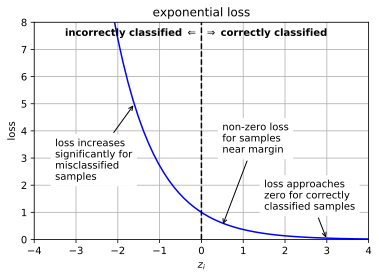

In [16]:
 lossfig

# Example on Iris data
- Too many weak-learners and AdaBoost carves out space for the outliers.
- Note: sklearn uses Real AdaBoost by default
  - uses class probabilities instead of binary class predictions
  - (usually converges faster and has lower error)

In [17]:
# load iris data each row is (petal length, sepal width, class)
irisdata = loadtxt('iris2.csv', delimiter=',', skiprows=1)

X = irisdata[:,0:2]  # the first two columns are features (petal length, sepal width)
Y = irisdata[:,2]    # the third column is the class label (versicolor=1, virginica=2)

print(X.shape)

(100, 2)


In [18]:
# randomly split data into 50% train and 50% test set
trainX, testX, trainY, testY = \
  model_selection.train_test_split(X, Y, 
  train_size=0.5, test_size=0.5, random_state=4487)

print(trainX.shape)
print(testX.shape)

(50, 2)
(50, 2)


In [19]:
ns = [1, 3, 5, 100]

clf = {}
for i,n in enumerate(ns):
    clf[n] = ensemble.AdaBoostClassifier(n_estimators=n, random_state=4487)
    clf[n].fit(trainX, trainY)
    
axbox = [2.5, 7, 1.5, 4]

irisfig = plt.figure(figsize=(9,8))
for i,n in enumerate(ns):
    clfx = clf[n]
    plt.subplot(2,2,i+1)
    plot_boosting(clfx, axbox, trainX)
    plt.scatter(trainX[:,0], trainX[:,1], c=trainY, cmap=mycmap, edgecolors='k')
    plt.xlabel('petal length'); plt.ylabel('sepal width')
    plt.gca().xaxis.set_ticklabels([])
    plt.gca().yaxis.set_ticklabels([])
    trainerr = metrics.accuracy_score(trainY, clfx.predict(trainX))
    plt.title("n=" + str(n) + " (train acc={:.3f})".format(trainerr))
plt.close()

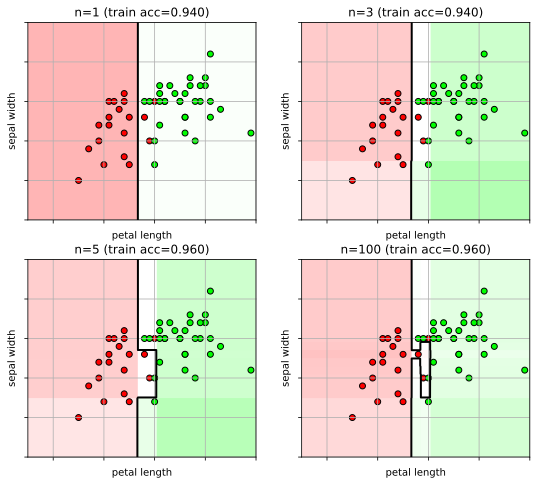

In [20]:
irisfig

- Two hyperparameters regularize boosting:
  1. the number of weak learners - how many boosting iterations
  2. the "learning rate" - a factor for scaling the contribution of each weak-learner
    - usually between 0 and 1.
    - Also called "shrinkage".
- Smaller learning rates require more weak learners.
- Estimate with cross-validation.

In [21]:
def extract_grid_scores(modelcv, paramgrid):
    "extract CV scores from GridSearchCV and put into a matrix"
    # get parameters
    pkeys = list(paramgrid.keys())
    
    # initialize empty score matrix
    scoresize = [len(paramgrid[p]) for p in pkeys]
    avgscores = zeros(scoresize)

    # fill in the matrix with run for each parameter set
    for rm,rp in zip(modelcv.cv_results_['mean_test_score'], modelcv.cv_results_['params']):
        # get the index into each of the parameter lists
        myind = [where(rp[p] == paramgrid[p]) for p in pkeys]
        avgscores[tuple(myind)] = rm    # put the score

    # location of best score
    bestind = [where(modelcv.best_params_[p] == paramgrid[p]) for p in pkeys]

    return avgscores, pkeys, bestind

In [22]:
# setup the list of parameters to try
paramgrid = {'learning_rate': logspace(-6,0,20), 
             'n_estimators': array([1, 2, 3, 5, 10, 15, 20, 25, 50, 100, 200, 500, 1000])
            }
print(paramgrid)

# setup the cross-validation object
# (NOTE: using parallelization in GridSearchCV, not in AdaBoost)
adacv = model_selection.GridSearchCV(ensemble.AdaBoostClassifier(random_state=4487),
                                 paramgrid, cv=5, n_jobs=-1)

# run cross-validation (train for each split)
adacv.fit(trainX, trainY);

print("best params:", adacv.best_params_)

{'learning_rate': array([1.00000000e-06, 2.06913808e-06, 4.28133240e-06, 8.85866790e-06,
       1.83298071e-05, 3.79269019e-05, 7.84759970e-05, 1.62377674e-04,
       3.35981829e-04, 6.95192796e-04, 1.43844989e-03, 2.97635144e-03,
       6.15848211e-03, 1.27427499e-02, 2.63665090e-02, 5.45559478e-02,
       1.12883789e-01, 2.33572147e-01, 4.83293024e-01, 1.00000000e+00]), 'n_estimators': array([   1,    2,    3,    5,   10,   15,   20,   25,   50,  100,  200,
        500, 1000])}
best params: {'learning_rate': 0.026366508987303555, 'n_estimators': 2}


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


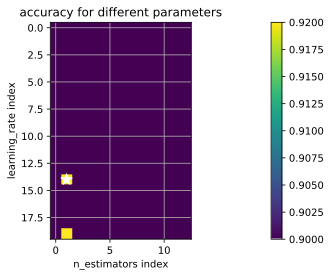

In [23]:
(avgscores, pnames, bestind) = extract_grid_scores(adacv, paramgrid)
paramfig = plt.figure()
plt.imshow(avgscores, interpolation='nearest')
plt.plot(bestind[1], bestind[0], '*w', markersize=12)
plt.ylabel(pnames[0] + ' index'); plt.xlabel(pnames[1] + ' index')
plt.grid(True)
plt.title('accuracy for different parameters')
plt.colorbar()
plt.axis('image');

In [24]:
# predict from the model
predY = adacv.predict(testX)

# calculate accuracy
acc      = metrics.accuracy_score(testY, predY)
print("test accuracy =", acc)

test accuracy = 0.82


In [25]:
ifig2 = plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
plot_boosting(adacv.best_estimator_, axbox, trainX)
plt.scatter(trainX[:,0], trainX[:,1], c=trainY, cmap=mycmap, edgecolors='k')
plt.xlabel('petal length'); plt.ylabel('sepal width')
plt.gca().xaxis.set_ticklabels([])
plt.gca().yaxis.set_ticklabels([])
plt.title("training data")

plt.subplot(1,2,2)
plot_boosting(adacv.best_estimator_, axbox, trainX)
plt.scatter(testX[:,0], testX[:,1], c=testY, cmap=mycmap, edgecolors='k')
plt.xlabel('petal length'); plt.ylabel('sepal width')
plt.gca().xaxis.set_ticklabels([])
plt.gca().yaxis.set_ticklabels([])
plt.title("testing data")
plt.close()

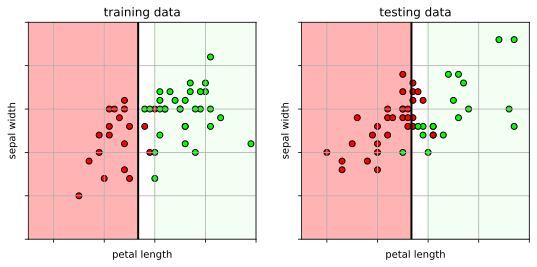

In [26]:
ifig2

- Boosting can do feature selection
  - each decision stump classifier looks at one feature
- One of the original face detection methods (Viola-Jones) used Boosting.
  - extract a lot of image features from the face
  - during training, Boosting learns which ones are the most useful.  
![](imgs/VJ-haar.png)

# Gradient Boosting
- Variant of boosting
  - each iteration fits the residual between the current predictions and the true labels.
  - the residual is computed as the gradient of the loss function.
- It's a gradient descent algorithm
  - in each iteration, the weak learner fits the gradient of the loss
    - $h_t(\mathbf{x}) \approx \frac{dL}{d\mathbf{x}}$
 - and adds it to the function:
   - $f_t(\mathbf{x}) = f_{t-1}(\mathbf{x}) - \alpha_t h_t(\mathbf{x}) \approx  f_{t-1}(\mathbf{x}) - \alpha_t \frac{dL}{d\mathbf{x}}$
  - Generalizes boosting to other loss functions.

- Typically uses decision trees for the weak learner:
  - At each node, move down the tree based on that node's criteria.
  - leaf node contains the prediction
<center>
<table><tr><td><img width="500" src="imgs/DT.png"></td><td><img width="500" src="imgs/DT-eg.png"></td></tr></table></center>

...

In [27]:
import xgboost as xgb
ns = [10, 50, 100, 1000]

xgbfig = plt.figure(figsize=(9,9))
for i,n in enumerate(ns):
    clf = xgb.XGBClassifier(objective="binary:logistic", random_state=42, n_estimators=n)
    clf.fit(X3, Y3)
    
    plt.subplot(2,2,i+1)
    plot_boosting(clf, axbox3, X3)
    plt.scatter(X3[:,0], X3[:,1], c=Y3, cmap=mycmap, edgecolors='k')
    plt.xlabel('$x_1$'); plt.ylabel('$x_2$')
    plt.gca().xaxis.set_ticklabels([])
    plt.gca().yaxis.set_ticklabels([])
    plt.title('iter '+str(n) + " classifier")
plt.close()

# Example
- more iterations tends to overfit severely
  - because the "weak" classifier is actually a strong (decision tree).

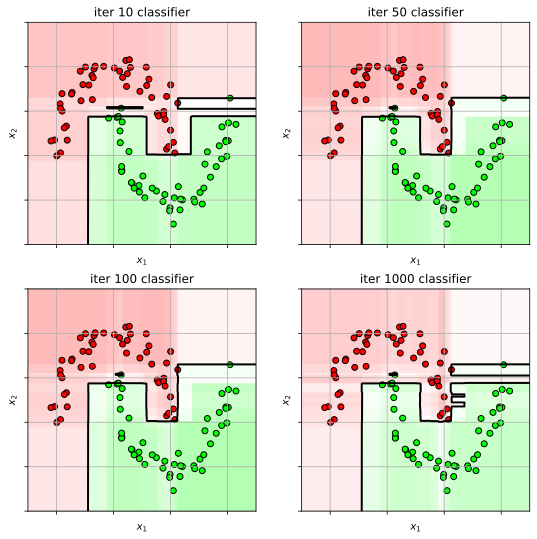

In [28]:
xgbfig

# Cross-validation
- select the best hyperparameters
  - number of estimators
  - learning rate (shrinkage term)

In [29]:
# use the XGBoost package, compatible with sklearn
import xgboost as xgb

# use "multi:softprob" for multi-class classification
xclf = xgb.XGBClassifier(objective="binary:logistic", random_state=4487)

# setup the list of parameters to try
paramgrid = {'learning_rate': logspace(-6,0,20), 
             'n_estimators': array([1, 2, 3, 5, 10, 15, 20, 25, 50, 100, 200, 500, 1000])
            }
print(paramgrid)

# setup the cross-validation object
xgbcv = model_selection.GridSearchCV(xclf, paramgrid, cv=5, n_jobs=-1)

# run cross-validation (train for each split)
xgbcv.fit(X3, Y3);

print("best params:", xgbcv.best_params_)

{'learning_rate': array([1.00000000e-06, 2.06913808e-06, 4.28133240e-06, 8.85866790e-06,
       1.83298071e-05, 3.79269019e-05, 7.84759970e-05, 1.62377674e-04,
       3.35981829e-04, 6.95192796e-04, 1.43844989e-03, 2.97635144e-03,
       6.15848211e-03, 1.27427499e-02, 2.63665090e-02, 5.45559478e-02,
       1.12883789e-01, 2.33572147e-01, 4.83293024e-01, 1.00000000e+00]), 'n_estimators': array([   1,    2,    3,    5,   10,   15,   20,   25,   50,  100,  200,
        500, 1000])}
best params: {'learning_rate': 0.012742749857031322, 'n_estimators': 1000}


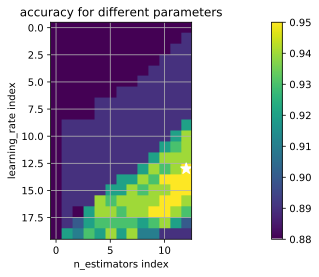

In [30]:
(avgscores, pnames, bestind) = extract_grid_scores(xgbcv, paramgrid)
paramfig = plt.figure()
plt.imshow(avgscores, interpolation='nearest')
plt.plot(bestind[1], bestind[0], '*w', markersize=12)
plt.ylabel(pnames[0] + ' index'); plt.xlabel(pnames[1] + ' index')
plt.grid(True)
plt.title('accuracy for different parameters')
plt.colorbar()
plt.axis('image');

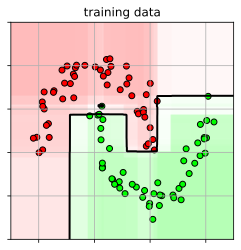

In [31]:
ifig2 = plt.figure(figsize=(4,4))
plot_boosting(xgbcv.best_estimator_, axbox3, X3)
plt.scatter(X3[:,0], X3[:,1], c=Y3, cmap=mycmap, edgecolors='k')
plt.gca().xaxis.set_ticklabels([])
plt.gca().yaxis.set_ticklabels([])
plt.title("training data")
plt.show()

- Since decision trees are used, there are a lot of hyperparameters to tune for the decision tree.
  - `max_depth`: maximum depth of the tree
  - `gamma`: minimum loss reduction in order to split a leaf.
  - `colsample_bytree`: fraction of features to randomly subsample when building a tree.  
  - `subsample`: fraction of training data to subsample during each boosting iteration (for each tree).

- **Problem:** Too many parameters to use grid-search!
- **Solution:** use randomized search
  - specify probability distributions for the parameters to try
    - `stats.uniform(a, b)` = uniform distribution between [a, a+b]
    - `stats.randint(a,b)` = random integeber between [a, b]

In [32]:
# setup dictionary of distributions for each parameter
paramsampler = {    
    "colsample_bytree": stats.uniform(0.7, 0.3),  # default=1
    "gamma":            stats.uniform(0, 0.5),    # default=0
    "max_depth":        stats.randint(2, 6),      # default=6
    "subsample":        stats.uniform(0.6, 0.4),  # default=1
    "learning_rate":    stats.uniform(.001,1),    # default=1 (could also use loguniform)
    "n_estimators":     stats.randint(10, 1000),
}

xclf = xgb.XGBClassifier(objective="binary:logistic", random_state=4487)

# cross-validation via random search
# n_iter = number of parameter combinations to try
xgbrcv = model_selection.RandomizedSearchCV(xclf, param_distributions=paramsampler, 
                            random_state=4487, n_iter=200, cv=5, 
                            verbose=1, n_jobs=-1)

xgbrcv.fit(X3, Y3)
print("best params:", xgbrcv.best_params_)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    3.1s


best params: {'colsample_bytree': 0.9682214619643752, 'gamma': 0.43411018169657967, 'learning_rate': 0.014847933781299671, 'max_depth': 4, 'n_estimators': 152, 'subsample': 0.6743715045033899}


[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   16.5s finished


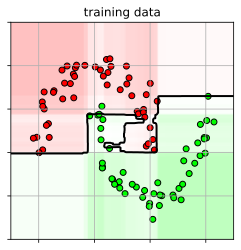

In [33]:
ifig2 = plt.figure(figsize=(4,4))
plot_boosting(xgbrcv.best_estimator_, axbox3, X3)
plt.scatter(X3[:,0], X3[:,1], c=Y3, cmap=mycmap, edgecolors='k')
plt.gca().xaxis.set_ticklabels([])
plt.gca().yaxis.set_ticklabels([])
plt.title("training data")
plt.show()

# Boosting Summary
- **Ensemble Classifier:**
  - Combine the outputs of many "weak" classifiers to make a "strong" classifier
- **Training:**
  - In each iteration, 
    - training data is re-weighted based on whether it is correctly classified or not.
    - weak classifier focuses on misclassified data from previous iterations.
  - Use cross-validation to pick number of weak learners.

- **Advantages:**
  - Good generalization performance
  - Built-in features selection - decision stump selects one feature at a time.
- **Disadvantages:**
  - Sensitive to outliers.

# Outline
1. Nonlinear classifiers
2. Kernel trick and kernel SVM
3. **Ensemble Methods - Boosting, Random Forests**
4. Classification Summary

# Decision Tree
- Simple "Rule-based" classifier
  - At each node, move down the tree based on that node's criteria.
  - leaf node contains the prediction
- **Advantage:** can create complex conjunction of rules
- **Disadvantage:** easy to overfit by itself
  - can fix with bagging!

<center>
<table><tr><td><img width="500" src="imgs/DT.png"></td><td><img width="500" src="imgs/DT-eg.png"></td></tr></table></center>

...

# Random Forest Classifier
- Use **bagging** to make an ensemble of Decision Tree Classifiers
  - for each _Decision Tree Classifier_
    - create a new training set by randomly sampling from the training set
    - for each split in a tree, select a random subset of features to use
- for a test sample, the prediction is aggregated over all trees.

<center><img src="imgs/RF.jpg"></center>

...

In [34]:
# learn a RF classifier
# use 4 trees
clf = ensemble.RandomForestClassifier(n_estimators=4, random_state=4487, n_jobs=-1)
clf.fit(X3, Y3)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=4, n_jobs=-1,
                       oob_score=False, random_state=4487, verbose=0,
                       warm_start=False)

In [35]:
def plot_rf(model, axbox, X):
    # grid points
    xr = [ linspace(axbox[0], axbox[1], 200), 
           linspace(axbox[2], axbox[3], 200) ]

    # make a grid for calculating the posterior, 
    #  then form into a big [N,2] matrix
    xgrid0, xgrid1 = meshgrid(xr[0], xr[1])
    allpts = c_[xgrid0.ravel(), xgrid1.ravel()]

    # calculate the decision function
    score = model.predict_proba(allpts)[:,1].reshape(xgrid0.shape)

    plt.imshow(score, origin='lower', extent=axbox, alpha=0.30, cmap=mycmap, 
               vmin=0, vmax=1, aspect='auto')

    plt.contour(xr[0], xr[1], score, levels=[0.5], linestyles='solid', colors='k')
    
    plt.axis(axbox); plt.grid(True)    

In [36]:
axbox = [-1.5, 2.5, -1, 1.5]

dtfig = plt.figure(figsize=(9,7))
for i,d in enumerate(clf.estimators_):
    plt.subplot(2,2,i+1)
    plot_rf(d, axbox, X3)
    plt.scatter(X3[:,0], X3[:,1], c=Y3, cmap=mycmap, edgecolors='k')
    plt.gca().xaxis.set_ticklabels([])
    plt.gca().yaxis.set_ticklabels([])
    plt.title("Decision Tree " + str(i+1))
plt.close()

rffig = plt.figure()
plot_rf(clf, axbox, X3)
plt.scatter(X3[:,0], X3[:,1], c=Y3, cmap=mycmap, edgecolors='k')
plt.colorbar()
plt.close()

- Here are the 4 decision trees 
  - each uses a different random sampling of original training set

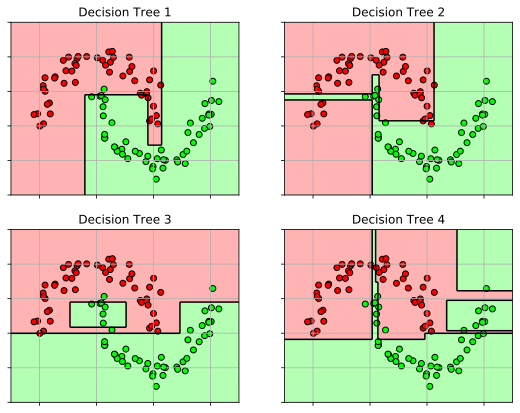

In [37]:
dtfig

- and the aggregated classifier

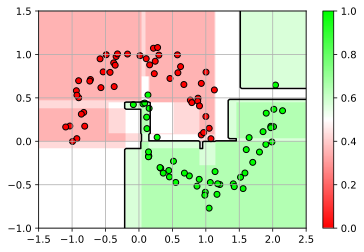

In [38]:
rffig

- Using more trees

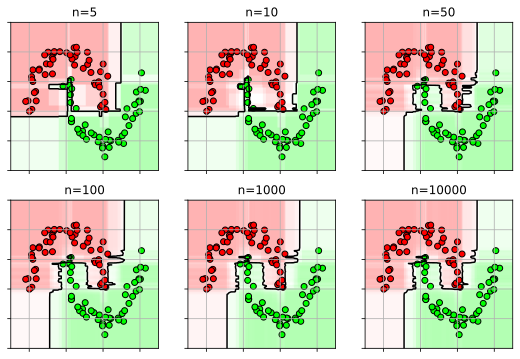

In [39]:
# learn RF classifiers for different n_estimators
plt.figure(figsize=(9,6))
clfs = {}
for i,n in enumerate([5, 10, 50, 100, 1000, 10000]):
    clfs[n] = ensemble.RandomForestClassifier(n_estimators=n, random_state=4487, n_jobs=-1)
    clfs[n].fit(X3, Y3)
        
    plt.subplot(2,3,i+1)
    plot_rf(clfs[n], axbox, X3)
    plt.scatter(X3[:,0], X3[:,1], c=Y3, cmap=mycmap, edgecolors='k')
    plt.gca().xaxis.set_ticklabels([])
    plt.gca().yaxis.set_ticklabels([])
    plt.title("n=" + str(n))
    

- Try on the iris data


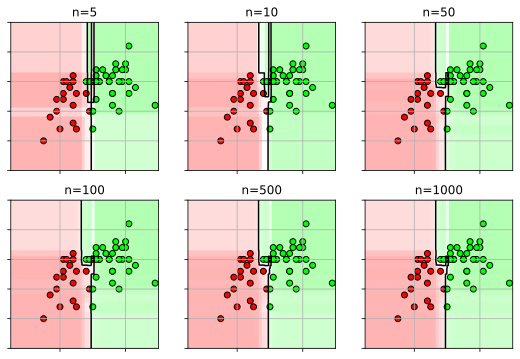

In [40]:
# learn RF classifiers for different n_estimators
plt.figure(figsize=(9,6))
clfs = {}
axbox = [2.5, 7, 1.5, 4]

for i,n in enumerate([5, 10, 50, 100, 500, 1000]):
    clfs[n] = ensemble.RandomForestClassifier(n_estimators=n, random_state=4487, n_jobs=-1)
    clfs[n].fit(trainX, trainY)
        
    plt.subplot(2,3,i+1)
    plot_rf(clfs[n], axbox, trainX)
    plt.scatter(trainX[:,0], trainX[:,1], c=trainY, cmap=mycmap, edgecolors='k')
    plt.gca().xaxis.set_ticklabels([])
    plt.gca().yaxis.set_ticklabels([])
    plt.title("n=" + str(n))

In [41]:
# predict from the model
predY = clfs[1000].predict(testX)

# calculate accuracy
acc      = metrics.accuracy_score(testY, predY)
print("test accuracy =", acc)

test accuracy = 0.78


In [42]:
axbox = [2.5, 7, 1.5, 4]

ifig3 = plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
plot_rf(clfs[1000], axbox, trainX)
plt.scatter(trainX[:,0], trainX[:,1], c=trainY, cmap=mycmap, edgecolors='k')
plt.xlabel('petal length'); plt.ylabel('sepal width')
plt.gca().xaxis.set_ticklabels([])
plt.gca().yaxis.set_ticklabels([])
plt.title("training data")

plt.subplot(1,2,2)
plot_rf(clfs[1000], axbox, trainX)
plt.scatter(testX[:,0], testX[:,1], c=testY, cmap=mycmap, edgecolors='k')
plt.xlabel('petal length'); plt.ylabel('sepal width')
plt.gca().xaxis.set_ticklabels([])
plt.gca().yaxis.set_ticklabels([])
plt.title("testing data")
plt.close()

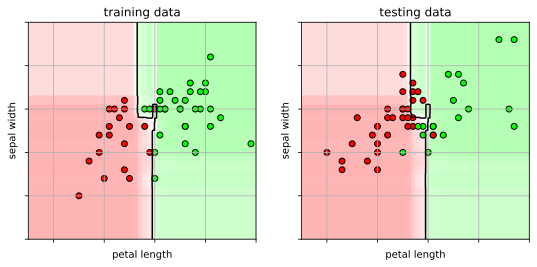

In [43]:
# classifier boundary w/ training and test data
ifig3

- Important parameters for cross-validation
  - `max_features` - maximum number of features used for each split
  - `max_depth` - maximum depth of a decision tree
  - `min_samples_split` - minimum fraction of samples to split a node.
  - `min_samples_leaf` - min fraction of samples in a leaf node.

In [44]:
# setup the list of parameters to try
paramsampler = {#'max_features': stats.uniform(0,1.0),
                 'max_depth':         stats.randint(1,10),
                 'min_samples_split': stats.uniform(0,0.5), 
                 'min_samples_leaf':  stats.uniform(0,0.5),
               }

# setup the cross-validation object
rfrcv = model_selection.RandomizedSearchCV(
                            ensemble.RandomForestClassifier(n_estimators=100, random_state=4487, n_jobs=-1),
                            param_distributions=paramsampler, 
                            random_state=4487, n_iter=1000, cv=5, 
                            verbose=1, n_jobs=-1)

# run cross-validation (train for each split)
rfrcv.fit(trainX, trainY);

print("best params:", rfrcv.best_params_)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
exception calling callback for <Future at 0x1264e24d0 state=finished raised TerminatedWorkerError>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/joblib/externals/loky/_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "/usr/local/lib/python3.7/site-packages/joblib/parallel.py", line 340, in __call__
    self.parallel.dispatch_next()
  File "/usr/local/lib/python3.7/site-packages/joblib/parallel.py", line 768, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "/usr/local/lib/python3.7/site-packages/joblib/parallel.py", line 834, in dispatch_one_batch
    self._dispatch(tasks)
  File "/usr/local/lib/python3.7/site-packages/joblib/parallel.py", line 753, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/usr/local/lib/python3.7/site-packages/joblib/_parallel_backends.py", line 543, in apply_async
    

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker. The exit codes of the workers are {SIGABRT(-6)}

In [ ]:
axbox = [2.5, 7, 1.5, 4]

ifig3 = plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
plot_rf(rfrcv.best_estimator_, axbox, trainX)
plt.scatter(trainX[:,0], trainX[:,1], c=trainY, cmap=mycmap, edgecolors='k')
plt.xlabel('petal length'); plt.ylabel('sepal width')
plt.gca().xaxis.set_ticklabels([])
plt.gca().yaxis.set_ticklabels([])
plt.title("training data")

plt.subplot(1,2,2)
plot_rf(rfrcv.best_estimator_, axbox, trainX)
plt.scatter(testX[:,0], testX[:,1], c=testY, cmap=mycmap, edgecolors='k')
plt.xlabel('petal length'); plt.ylabel('sepal width')
plt.gca().xaxis.set_ticklabels([])
plt.gca().yaxis.set_ticklabels([])
plt.title("testing data")
plt.close()

- Result

In [ ]:
ifig3

In [ ]:
# predict from the model
predY = rfrcv.predict(testX)

# calculate accuracy
acc      = metrics.accuracy_score(testY, predY)
print("test accuracy =", acc)

# Random Forest Summary

- **Ensemble Classifier & Training:**
  - aggregate predictions over several decision trees
  - trained using different subsets of data, and different subsets of features.
- **Advantages**
  - non-linear decision boundary. 
  - can do feature selection.
  - good generalization.
  - fast.
- **Disadvantages**
  - can be sensitive to outliers
  - based on trees -- cannot well represent "diagonal" decision boundaries.
